In [93]:
import requests
import json

API_KEY = "797dacab93a96c4a7e0ab91052873c8c"
BASE_URL = "https://api.themoviedb.org/3"

JSONFILE = "movies.json"

def load():
    try:
        with open(JSONFILE, "r", encoding="utf-8") as f:
            content=f.read()
            if len(content)!=0:
                 return json.loads(content)
            else:
                return {"last_page": 0, "movies": {}}
    except FileNotFoundError:
        return {"last_page": 0, "movies": {}}


def genref():
    url = f"{BASE_URL}/genre/movie/list"
    params = {"api_key": API_KEY, "language": "en-US"}
    response = requests.get(url, params=params)
    if response.status_code != 200:
        return {}
    return {g["id"]: g["name"] for g in response.json().get("genres", [])}


def savepages(data):
    with open(JSONFILE, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

genreidstuff=genref()
def main_fetch(loadpages=5):
    data = load()
    last_page = data["last_page"]
    moviesseznam = data["movies"]

    for page in range(last_page + 1, last_page + loadpages + 1):
        url = f"{BASE_URL}/movie/popular"
        params = {"api_key": API_KEY, "language": "en-US", "page": page}
        response = requests.get(url, params=params)
        if response.status_code != 200:
            print(f"Error fetching page {page}")
            continue
        movies = response.json().get("results", [])
        for movie in movies:
            title = movie.get("title")
            genre_ids = movie.get("genre_ids", [])
            genres = [genreidstuff.get(gid, "Unknown") for gid in genre_ids]

            moviesseznam[title] = {
                    "genres": genres,
                    "release_date": movie.get("release_date"),
                    "vote_average": movie.get("vote_average"),
                    "vote_count": movie.get("vote_count"),
                    "synopsis": movie.get("overview")
                }
    if loadpages!="":
        data["last_page"] = last_page + loadpages
        data["movies"] = moviesseznam
        savepages(data)
    return moviesseznam


In [94]:
from datetime import datetime
def datefilter(date, mini, maxi):
    try:
        movie_date = datetime.strptime(date, "%Y-%m-%d")
        min_date = datetime.strptime(mini, "%d.%m.%Y")
        max_date = datetime.strptime(maxi, "%d.%m.%Y")
    except:
        return False
    return min_date < movie_date < max_date

 
def checkforfilter(filterlist, data):#filterlist = [genrelist,genrenonlist,timerange,rating,totalrates]
    genres=data["genres"]
    date=data["release_date"]
    rating=data["vote_average"]
    totalvotes=data["vote_count"]
    for neededgenre in filterlist[0]:
        if neededgenre not in genres:
            return False
    for badgenre in filterlist[1]:
        if badgenre in genres:
            return False
    
    if rating<float(filterlist[3]) or totalvotes<float(filterlist[4]):
        return False
    return    datefilter(date,filterlist[2][0],filterlist[2][1])
       
       #just if the user inputs a non existant genre
def existantgenres(seznam):
    listmain=[]
    for movie in seznam:
        for genre in seznam[movie]["genres"]:
            if genre not in listmain:
                listmain.append(genre) 
    return listmain

def filter(filterlist,seznam):
    seznammain={}
    for movie in seznam:
        data=seznam[movie]
        if checkforfilter(filterlist,data):
            seznammain[movie]=seznam[movie]
    return seznammain


In [95]:

import pandas as pd
def findrecommendation(movieseznam,description):
    description=description.lower().split()
    for word in description:
        if len(word)>5:
            description.append(word[:4]) #for longer words we can search for their prepone
    deletewords={"the", "is", "are", "of", "and", "to", "an", "a"}
    description=[word for word in description if word not in deletewords]
    moviepoints=[]
    for title in movieseznam:
        synopsis=movieseznam[title]["synopsis"].lower()
        points=0
        for word in description:
            if word in synopsis: #counts if there is a word with a word e.g. teen-> teenager
                points+=1
        moviepoints.append([
                            title,
                            points, 
                            movieseznam[title]["release_date"],
                            movieseznam[title]["vote_average"],
                            movieseznam[title]["genres"],            
                            synopsis])
    df = pd.DataFrame(moviepoints, columns=["title","points","release_date", "rating", "genres", "synopsis"])
    df = df.sort_values(by=["points", "rating"], ascending=[False, False])
    return  df



Scanning 4232 movies in total


title,release_date,rating,genres,synopsis
Fate/stay night: Heaven's Feel III. Spring Song,2020-08-15,7.754,"Animation, Romance, Fantasy, Action, Drama","as sakura drowns in the murky darkness of the sins she has committed, shirou's vow to protect her at all costs leads him into a raging battle to put an end to the holy grail war. will shirou's wish reach sakura even as he challenges fate itself in a desperate battle against the rising tide?"
The Testament of Sister New Devil: Departures,2018-01-27,7.700,"Animation, Action, Romance, Fantasy","the first movie based on the tv series the testament of sister new devil, takes place right after the season 2 final."
Rurouni Kenshin: The Beginning,2021-06-04,7.676,"Action, Adventure, Drama, Romance","before he was a protector, kenshin was a fearsome assassin known as battosai. but when he meets gentle tomoe yukishiro, a beautiful young woman who carries a huge burden in her heart, his life will change forever."
True Romance,1993-09-09,7.546,"Action, Crime, Romance","clarence marries hooker alabama, steals cocaine from her pimp, and tries to sell it in hollywood, while the owners of the coke try to reclaim it."
Scott Pilgrim vs. the World,2010-08-12,7.489,"Action, Comedy, Romance","as bass guitarist for a garage-rock band, scott pilgrim has never had trouble getting a girlfriend; usually, the problem is getting rid of them. but when ramona flowers skates into his heart, he finds she has the most troublesome baggage of all: an army of ex-boyfriends who will stop at nothing to eliminate him from her list of suitors."
Legends of the Fall,1994-12-23,7.395,"Drama, Western, Romance, War, Action","in early 20th-century montana, col. william ludlow lives on a ranch in the wilderness with his sons, alfred, tristan, and samuel. eventually, the unconventional but close-knit family are bound by loyalty, tested by war, and torn apart by love, as told over the course of several decades in this epic saga."
"Lust, Caution",2007-09-24,7.200,"Action, Drama, Romance, Thriller","during world war ii, a secret agent must seduce and assassinate an official who works for the japanese puppet government in shanghai."
Once Upon a Time in High School,2004-01-15,7.200,"Romance, Drama, Action",a model student transfers to the notorious jungmoon high school known for its severe corporal punishment by teachers and power struggles between school gangs.
Maleficent,2014-05-28,7.089,"Fantasy, Adventure, Action, Family, Romance","a beautiful, pure-hearted young woman, maleficent has an idyllic life growing up in a peaceable forest kingdom, until one day when an invading army threatens the harmony of the land. she rises to be the land's fiercest protector, but she ultimately suffers a ruthless betrayal – an act that begins to turn her heart into stone. bent on revenge, maleficent faces an epic battle with the invading king's successor and, as a result, places a curse upon his newborn infant aurora. as the child grows, maleficent realizes that aurora holds the key to peace in the kingdom – and to maleficent's true happiness as well."
Pearl Harbor,2001-05-21,6.942,"War, Romance, History, Action","the lifelong friendship between rafe mccawley and danny walker is put to the ultimate test when the two ace fighter pilots become entangled in a love triangle with beautiful naval nurse evelyn johnson. but the rivalry between the friends-turned-foes is immediately put on hold when they find themselves at the center of japan's devastating attack on pearl harbor on dec. 7, 1941."


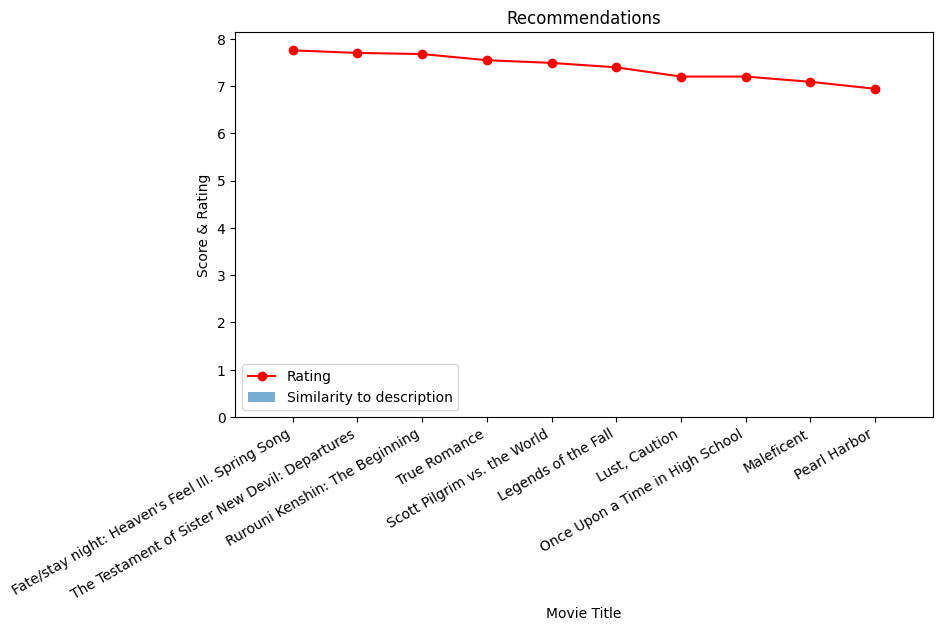

In [96]:

import matplotlib.pyplot as plt

def main():      
    a=int(input("How many more movies should we load?"))
    if a!=0:
        a=a//20+1 #a should load pages..
    movieseznam=main_fetch(a)
    print(f"Scanning {len(movieseznam)} movies in total")
    genrelist=existantgenres(movieseznam)
    if input("customize your filters?:(input yes or no)")=="yes":
        genreneeded=[]
        genrenon=[]

        while True:
            inp=(input("Do you want any more specific genres(when you are done input 'No'): "))
            if inp=="No":
                break
            if inp not in genrelist:
                print("genre doesnt exist make sure to use an uppercaseletter exemple: Horror")
            else:
                genreneeded.append(inp)
        while True:
            inp=(input("Do you want to remove all of a certain genre(when you are done input 'No'): "))
            if inp=="No":
                break
            if inp not in genrelist:
                print("genre doesnt exist make sure to use an uppercaseletter exemple: Romance")
            elif inp in genreneeded:
                print("You want to see a movie with and without "+str(inp)+"? i dont think that makes sense..")
            else:
                genrenon.append(inp)
        datemin=input("write the earliest possible release date for your movie(day.month.year): ")
        datemax=input("write the latest possible release date for your movie(day.month.year): ")
        minscore=input("Minimum rating?")
        mincount=input("Minimum number of voters?")

        if int(datemin.split(".")[len(datemin.split("."))-1])<1000:
            datemin="1.1.1000"
        testlistforfilter=[genreneeded,genrenon,[datemin,datemax],minscore,mincount]

        jsonseznam = load()
        jsonseznam["testlistforfilter"] = testlistforfilter
        savepages(jsonseznam)
    else:
        try:
            with open (JSONFILE, encoding="utf-8") as f:
               testlistforfilter = json.load(f)["testlistforfilter"]
        except:
            testlistforfilter=[[],[],["1.1.1000","1.1.3000"],0,0]#it means the person has never used this b4 and also doesnt want to add any filters


    mainseznam = filter(testlistforfilter, movieseznam)
    if len(mainseznam)==0:
        print("No such movie was collected")
        return None

    description=input("Write a further description of the movie, keywords: ")    
    #end of inputs

    df = findrecommendation(mainseznam, description)
    topgraph =df.head(10)
    topoptions = df.head(10)[["title", "release_date", "rating", "genres", "synopsis"]].reset_index(drop=True)
    topoptions["genres"]=topoptions["genres"].str.join(", ")
    topoptions['rating'] = topoptions['rating'].map('{:.3f}'.format)
    
    data = (
        topoptions.style
        .hide(axis="index") 
        .set_properties(subset=["synopsis"], **{'white-space': 'pre-wrap'})    
        .apply(lambda row: ['background-color: red' if row.name == 0 else '' for _ in row], axis=1)
    )
    display(data)
    
    plt.figure(figsize=(9, 5))
    plt.bar(topgraph["title"], topgraph["points"], label="Similarity to description",alpha=0.6)
    plt.plot(topgraph["title"], topgraph["rating"], color="red", marker="o", label="Rating")
    
    plt.xlabel("Movie Title")
    plt.ylabel("Score & Rating")
    plt.title("Recommendations")
    plt.xticks(rotation=30, ha="right")
    plt.legend()
    plt.show()




if __name__ == "__main__":
    main()
